# Multidimensional Array Exercise

In this exercise, you will apply the principles of using multidimensional arrays to estimate global mean temperature from a gridded dataset, accounting for the fact that grid cells become smaller at the poles.

In a dataset with evenly spaced latitude and longitude values, the meridians converge at the poles, making the cells smaller.  The area of the cells is proportional to the cosine of the latitude $\theta$ (in radians):

$$ \Delta A = R_{\oplus}^2 \Delta \theta \Delta \phi \cdot \cos(\theta) $$
$$ \Delta A \propto \cos(\theta)$$

Therefore, when calculating the global average of a quantity (like temperature), the values need to be weighted by $\cos(\theta)$.

**Goal**: correctly calculate a timeseries of global mean temperature from the dataset below

Instructions:

1. execute the cell below to download the dataset (this is the one we used to make sound in the first class)
1. the cell includes code to extract the latitude values (in degrees; `lat`) and the temperature field `temp_3d` as numpy arrays
1. calculate and plot a timeseries of global mean temperature, using the $cos(\theta)$ weighting

In [1]:
""" Read in the data """
import xarray as xr

# set the year we want to download
year = 1983 
# set the URL for the NCEP/DOE Reanalysis 2 data file
url = f"https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis2/gaussian_grid/air.2m.gauss.{year}.nc"

# set the name of the file we want to download to
output_file = f"air.2m.gauss.{year}.nc"

# download the data file
# NOTE: the use of ! at the beginning of the line indicates that this is a shell command, not python code -- though it does use some python code.  How, why?
# check first if the file exists; don't re-download if it does
import os
if not os.path.exists(output_file):
    ! curl --output {output_file} {url}

# (a side note for anyone familiar with xarray: you might ask why I don't use xarray to directly open the file from the URL (or the related OpenDAP URL)?  The reason is that it takes several minutes to open this 55 MB file, whereas directly downloading it takes only a couple seconds!)

# open the dataset using xarray
temp_ds = xr.open_dataset(output_file, chunks = -1)

# get the latitude and temperature values as numpy arrays
lat = temp_ds.lat.values
temp_3d = temp_ds.air.values

# also get the time array
time = temp_ds.time.values

In [2]:
""" Examine the arrays. """
print(f"temp_3d.shape: ",temp_3d.shape)
print(f"lat.shape: ",lat.shape)
print("time.shape: ", time.shape)



temp_3d.shape:  (1460, 1, 94, 192)
lat.shape:  (94,)
time.shape:  (1460,)


Okay, so the `temp_3d` field is technically 4D...it has a pesky dimension of length 1. We can use `squeeze` to remove that dimension

In [3]:
""" Reduce dimensionality of `temp_3d` """
temp_3d = temp_3d.squeeze()

In [4]:
""" Calculate the weights. """
import numpy as np

# convert lat to radians
lat_rad = np.deg2rad(lat)

# take the cos of lat
cos_lat = np.cos(lat_rad)

If we want the area-weighted mean temperature, this corresponds to the following mathematical operation:

$$ \overline{T}_k = \frac{\sum\limits_{i = 0}^{N-1} \sum\limits_{j = 0}^{M-1} w_{ij} \cdot T_{ijk}}{\sum\limits_{i = 0}^{N-1} \sum\limits_{j = 0}^{M-1} w_{ij}}$$

where the indices $i$ and $j$ correspond to latitude and longitude, $k$ corresponds to time, $w_{ij}$ are the weights for each grid cell and $T_{ijk}$ is `temp_3d`--the temperatures at every point in space and time.

This can be simplified if we ensure that the weights are *normalized* such that $ \sum\limits_{i = 0}^{N-1} w_{i} = 1$ (i.e., if we divide `cos_lat` by `sum(cos_lat)`), removing the denominator:

$$ \overline{T}_k = \frac{1}{M} \sum\limits_{i = 0}^{N-1} \sum\limits_{j = 0}^{M-1} w_{i} \cdot T_{ijk}$$

(The $1/M$ is needed in this version since we don't have weights in the longitude direction, so $1/M$ is needed for the longitudinal mean.)

These two formulae correspond to two different approaches we can use in python:

1. make `cos_lat` into a 3D array, using `broadcasting`
2. normalize the weights and employ broadcasting

We'll see both below.


Since we'll generate the same plot a couple times, I'll make a function to do this in the first approach's cell.

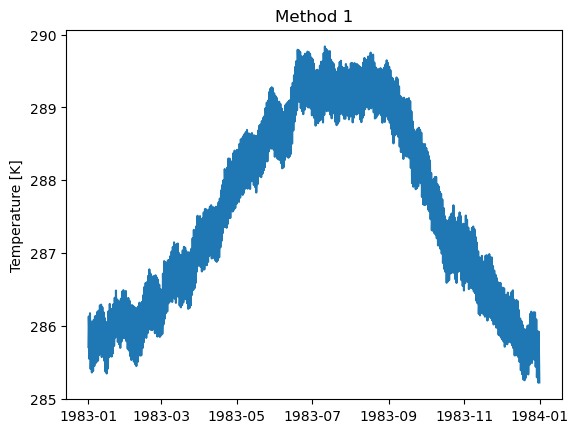

In [5]:
""" Approach 1: 2D broadcasting. """

# broadcast cos_lat to a 3D array and multiply by temp_3d
weights3d = cos_lat[np.newaxis,:,np.newaxis] * np.ones_like(temp_3d)

# do the weighted average
tbar_method1 = np.sum(weights3d * temp_3d, axis = (1,2)) / np.sum(weights3d, axis = (1,2))

import matplotlib.pyplot as plt

# generate a function for plotting
def plot_temps(tbar, method = 1):
    """ Plots a timeseries of average temperature. """
    fig, ax = plt.subplots()

    ax.plot(time, tbar)
    ax.set_xlabel("")
    ax.set_ylabel("Temperature [K]")
    ax.set_title(f"Method {method}")
    plt.show()

plot_temps(tbar_method1, method = 1)

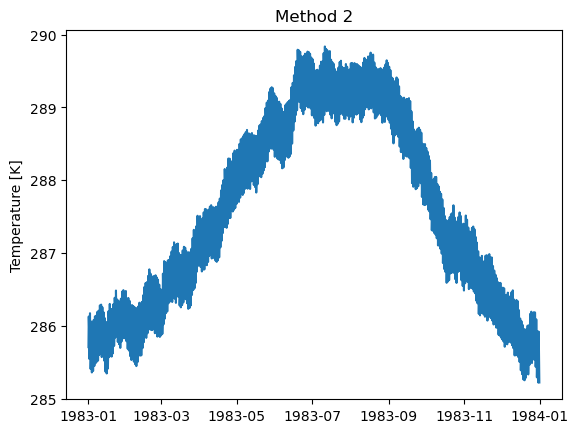

In [6]:
""" Approach 2: 1D broadcasting. """

# broadcast cos_lat so we can multiply with temperature
weights1d = cos_lat[np.newaxis, :, np.newaxis]

# normalize the weights and divide by the number of longitudes
ntime, nlat, nlon = temp_3d.shape
weights1d = weights1d / np.sum(weights1d) / nlon

# calculate the average
tbar_method2 = np.sum(weights1d*temp_3d, axis = (1,2))

plot_temps(tbar_method2, method = 2)